In [1]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Jun__6_02:18:23_PDT_2024
Cuda compilation tools, release 12.5, V12.5.82
Build cuda_12.5.r12.5/compiler.34385749_0


In [2]:
!pip install nvcc4jupyter


In [3]:
%load_ext nvcc4jupyter

Detected platform "Kaggle". Running its setup...
Updating the package lists...
Installing nvidia-cuda-toolkit, this may take a few minutes...
Source files will be saved in "/tmp/tmpaob0r6th".


In [40]:
%%cuda
#include <stdio.h>
#include <stdlib.h>
#include <cuda_runtime.h>
#include <sys/time.h>

#define CHECK_CUDA(call) \
    if ((call) != cudaSuccess) { \
        fprintf(stderr, "CUDA error at %s:%d\n", __FILE__, __LINE__); \
        exit(EXIT_FAILURE); \
    }

double getCurrentTime() {
    struct timeval tv;
    gettimeofday(&tv, NULL);
    return (double)tv.tv_sec + (double)tv.tv_usec / 1000000.0;
}

const int M = 4, K = 4, N = 2;
const int NUM_RUNS = 10;

float h_dense_B[K * N] = {
    1, 2,
    3, 4,
    5, 6,
    7, 8
};

float h_dense_C[M * N];

int coo_rows[] = {0, 0, 1, 2, 2, 2, 3};
int coo_cols[] = {0, 2, 1, 0, 2, 3, 3};
float coo_vals[] = {1, 2, 3, 4, 5, 6, 7};
int nnz = sizeof(coo_vals) / sizeof(coo_vals[0]);

// Kernel declarations (same as before)
__global__ void spmm_coo(int *rows, int *cols, float *vals, float *B, float *C, int nnz, int N) {
    int i = blockIdx.x * blockDim.x + threadIdx.x;
    if (i < nnz) {
        int row = rows[i], col = cols[i];
        float val = vals[i];
        for (int n = 0; n < N; n++) {
            atomicAdd(&C[row * N + n], val * B[col * N + n]);
        }
    }
}

__global__ void spmm_csr(int *row_ptr, int *cols, float *vals, float *B, float *C, int M, int N) {
    int row = blockIdx.x * blockDim.x + threadIdx.x;
    if (row < M) {
        for (int i = row_ptr[row]; i < row_ptr[row + 1]; i++) {
            int col = cols[i];
            float val = vals[i];
            for (int n = 0; n < N; n++) {
                C[row * N + n] += val * B[col * N + n];
            }
        }
    }
}
__global__ void spmm_ell(int *indices, float *data, int max_nnz, float *B, float *C, int M, int N) {
    int row = blockIdx.x * blockDim.x + threadIdx.x;
    if (row < M) {
        for (int j = 0; j < max_nnz; j++) {
            int col = indices[row * max_nnz + j];
            float val = data[row * max_nnz + j];
            if (val != 0) {
                for (int n = 0; n < N; n++) {
                    C[row * N + n] += val * B[col * N + n];
                }
            }
        }
    }
}

__global__ void spmm_ellr(int *indices, float *data, int *lengths, int max_nnz, float *B, float *C, int M, int N) {
    int row = blockIdx.x * blockDim.x + threadIdx.x;
    if (row < M) {
        int len = lengths[row];
        for (int j = 0; j < len; j++) {
            int col = indices[row * max_nnz + j];
            float val = data[row * max_nnz + j];
            for (int n = 0; n < N; n++) {
                C[row * N + n] += val * B[col * N + n];
            }
        }
    }
}
__global__ void spmm_dia(int *offsets, float *data, int num_diags, float *B, float *C, int M, int N) {
    int row = blockIdx.x * blockDim.x + threadIdx.x;
    if (row < M) {
        for (int d = 0; d < num_diags; d++) {
            int col = row + offsets[d];
            if (col >= 0 && col < K) {
                float val = data[d * M + row];
                if (val != 0) {
                    for (int n = 0; n < N; n++) {
                        C[row * N + n] += val * B[col * N + n];
                    }
                }
            }
        }
    }
}

__global__ void spmm_hyb_ell(int *ell_idx, float *ell_val, int ell_cols, float *B, float *C, int M, int N) {
    int row = blockIdx.x * blockDim.x + threadIdx.x;
    if (row < M) {
        for (int j = 0; j < ell_cols; j++) {
            float val = ell_val[row * ell_cols + j];
            int col = ell_idx[row * ell_cols + j];
            if (val != 0) {
                for (int n = 0; n < N; n++) {
                    C[row * N + n] += val * B[col * N + n];
                }
            }
        }
    }
}
__global__ void spmm_hyb_coo(int *coo_rows, int *coo_cols, float *coo_vals, int coo_nnz, float *B, float *C, int N) {
    int i = blockIdx.x * blockDim.x + threadIdx.x;
    if (i < coo_nnz) {
        int row = coo_rows[i];
        int col = coo_cols[i];
        float val = coo_vals[i];
        for (int n = 0; n < N; n++) {
            atomicAdd(&C[row * N + n], val * B[col * N + n]);
        }
    }
}

void print_matrix(float *C, int rows, int cols) {
    for (int i = 0; i < rows; i++) {
        for (int j = 0; j < cols; j++) {
            printf("%.1f ", C[i * cols + j]);
        }
        printf("\n");
    }
    printf("\n");
}

int compare_ints(const void* a, const void* b) {
    return (*(int*)a - *(int*)b);
}

void print_mean_execution_times(double *mean_times, const char **names, int count) {
    printf("\nMean Kernel Execution Times (averaged over %d runs):\n", NUM_RUNS);
    printf("+-----------+----------------+\n");
    printf("| Format    | Time (seconds) |\n");
    printf("+-----------+----------------+\n");
    for (int i = 0; i < count; i++) {
        printf("| %-9s | %14.6f |\n", names[i], mean_times[i]);
    }
    printf("+-----------+----------------+\n\n");
    
    // Print data in CSV format for easy plotting
    printf("CSV Format:\n");
    printf("Format,Time\n");
    for (int i = 0; i < count; i++) {
        printf("%s,%.6f\n", names[i], mean_times[i]);
    }
}

void run_coo(float *d_B, float *d_C, int *d_coo_rows, int *d_coo_cols, float *d_coo_vals, int block, double *execution_time) {
    double total_time = 0.0;
    for (int run = 0; run < NUM_RUNS; run++) {
        cudaMemset(d_C, 0, M * N * sizeof(float));
        double start = getCurrentTime();
        spmm_coo<<<(nnz + block - 1) / block, block>>>(d_coo_rows, d_coo_cols, d_coo_vals, d_B, d_C, nnz, N);
        cudaDeviceSynchronize();
        total_time += getCurrentTime() - start;
    }
    *execution_time = total_time / NUM_RUNS;
}

void run_csr(float *d_B, float *d_C, int *d_csr_row, int *d_csr_col, float *d_csr_val, int block, double *execution_time) {
    double total_time = 0.0;
    for (int run = 0; run < NUM_RUNS; run++) {
        cudaMemset(d_C, 0, M * N * sizeof(float));
        double start = getCurrentTime();
        spmm_csr<<<(M + block - 1) / block, block>>>(d_csr_row, d_csr_col, d_csr_val, d_B, d_C, M, N);
        cudaDeviceSynchronize();
        total_time += getCurrentTime() - start;
    }
    *execution_time = total_time / NUM_RUNS;
}

void run_ell(float *d_B, float *d_C, int *d_ell_idx, float *d_ell_val, int max_per_row, int block, double *execution_time) {
    double total_time = 0.0;
    for (int run = 0; run < NUM_RUNS; run++) {
        cudaMemset(d_C, 0, M * N * sizeof(float));
        double start = getCurrentTime();
        spmm_ell<<<(M + block - 1) / block, block>>>(d_ell_idx, d_ell_val, max_per_row, d_B, d_C, M, N);
        cudaDeviceSynchronize();
        total_time += getCurrentTime() - start;
    }
    *execution_time = total_time / NUM_RUNS;
}

void run_ellr(float *d_B, float *d_C, int *d_ell_idx, float *d_ell_val, int *d_lengths, int max_per_row, int block, double *execution_time) {
    double total_time = 0.0;
    for (int run = 0; run < NUM_RUNS; run++) {
        cudaMemset(d_C, 0, M * N * sizeof(float));
        double start = getCurrentTime();
        spmm_ellr<<<(M + block - 1) / block, block>>>(d_ell_idx, d_ell_val, d_lengths, max_per_row, d_B, d_C, M, N);
        cudaDeviceSynchronize();
        total_time += getCurrentTime() - start;
    }
    *execution_time = total_time / NUM_RUNS;
}

void run_dia(float *d_B, float *d_C, int *d_offsets, float *d_dia_data, int num_diags, int block, double *execution_time) {
    double total_time = 0.0;
    for (int run = 0; run < NUM_RUNS; run++) {
        cudaMemset(d_C, 0, M * N * sizeof(float));
        double start = getCurrentTime();
        spmm_dia<<<(M + block - 1) / block, block>>>(d_offsets, d_dia_data, num_diags, d_B, d_C, M, N);
        cudaDeviceSynchronize();
        total_time += getCurrentTime() - start;
    }
    *execution_time = total_time / NUM_RUNS;
}

void run_hyb(float *d_B, float *d_C, int *d_hyb_ell_idx, float *d_hyb_ell_val, int ell_cols, 
             int *d_hyb_coo_r, int *d_hyb_coo_c, float *d_hyb_coo_v, int hyb_coo_nnz, int block, double *execution_time) {
    double total_time = 0.0;
    for (int run = 0; run < NUM_RUNS; run++) {
        cudaMemset(d_C, 0, M * N * sizeof(float));
        double start = getCurrentTime();
        spmm_hyb_ell<<<(M + block - 1) / block, block>>>(d_hyb_ell_idx, d_hyb_ell_val, ell_cols, d_B, d_C, M, N);
        if (hyb_coo_nnz > 0) {
            spmm_hyb_coo<<<(hyb_coo_nnz + block - 1) / block, block>>>(d_hyb_coo_r, d_hyb_coo_c, d_hyb_coo_v, hyb_coo_nnz, d_B, d_C, N);
        }
        cudaDeviceSynchronize();
        total_time += getCurrentTime() - start;
    }
    *execution_time = total_time / NUM_RUNS;
}

int main() {
    float *d_B, *d_C;
    int *d_coo_rows, *d_coo_cols;
    float *d_coo_vals;
    int *d_csr_row, *d_csr_col;
    float *d_csr_val;
    int *d_ell_idx, *d_lengths;
    float *d_ell_val;
    int *d_offsets;
    float *d_dia_data;
    int *d_hyb_ell_idx, *d_hyb_coo_r, *d_hyb_coo_c;
    float *d_hyb_ell_val, *d_hyb_coo_v;

    CHECK_CUDA(cudaMalloc(&d_B, K * N * sizeof(float)));
    CHECK_CUDA(cudaMemcpy(d_B, h_dense_B, K * N * sizeof(float), cudaMemcpyHostToDevice));

    int block = 32;
    int num_kernels = 6;
    double mean_times[6];
    const char *kernel_names[6] = {"COO", "CSR", "ELL", "ELLR", "DIA", "HYB"};

    // ===== COO =====
    CHECK_CUDA(cudaMalloc(&d_coo_rows, nnz * sizeof(int)));
    CHECK_CUDA(cudaMalloc(&d_coo_cols, nnz * sizeof(int)));
    CHECK_CUDA(cudaMalloc(&d_coo_vals, nnz * sizeof(float)));
    CHECK_CUDA(cudaMemcpy(d_coo_rows, coo_rows, nnz * sizeof(int), cudaMemcpyHostToDevice));
    CHECK_CUDA(cudaMemcpy(d_coo_cols, coo_cols, nnz * sizeof(int), cudaMemcpyHostToDevice));
    CHECK_CUDA(cudaMemcpy(d_coo_vals, coo_vals, nnz * sizeof(float), cudaMemcpyHostToDevice));
    CHECK_CUDA(cudaMalloc(&d_C, M * N * sizeof(float)));
    
    run_coo(d_B, d_C, d_coo_rows, d_coo_cols, d_coo_vals, block, &mean_times[0]);
    cudaMemcpy(h_dense_C, d_C, M * N * sizeof(float), cudaMemcpyDeviceToHost);
    printf("COO Output:\n"); print_matrix(h_dense_C, M, N);

    // ===== CSR =====
    int csr_row_ptr[M + 1] = {0, 2, 3, 6, 7};
    CHECK_CUDA(cudaMalloc(&d_csr_row, (M + 1) * sizeof(int)));
    CHECK_CUDA(cudaMalloc(&d_csr_col, nnz * sizeof(int)));
    CHECK_CUDA(cudaMalloc(&d_csr_val, nnz * sizeof(float)));
    CHECK_CUDA(cudaMemcpy(d_csr_row, csr_row_ptr, (M + 1) * sizeof(int), cudaMemcpyHostToDevice));
    CHECK_CUDA(cudaMemcpy(d_csr_col, coo_cols, nnz * sizeof(int), cudaMemcpyHostToDevice));
    CHECK_CUDA(cudaMemcpy(d_csr_val, coo_vals, nnz * sizeof(float), cudaMemcpyHostToDevice));
    
    run_csr(d_B, d_C, d_csr_row, d_csr_col, d_csr_val, block, &mean_times[1]);
    cudaMemcpy(h_dense_C, d_C, M * N * sizeof(float), cudaMemcpyDeviceToHost);
    printf("CSR Output:\n"); print_matrix(h_dense_C, M, N);

    // ===== ELL =====
    int max_per_row = 3;
    int *ell_idx = (int*)malloc(M * max_per_row * sizeof(int));
    float *ell_val = (float*)malloc(M * max_per_row * sizeof(float));
    memset(ell_idx, 0, M * max_per_row * sizeof(int));
    memset(ell_val, 0, M * max_per_row * sizeof(float));
    for (int i = 0; i < nnz; i++) {
        int r = coo_rows[i], c = coo_cols[i];
        float v = coo_vals[i];
        for (int j = 0; j < max_per_row; j++) {
            if (ell_val[r * max_per_row + j] == 0) {
                ell_idx[r * max_per_row + j] = c;
                ell_val[r * max_per_row + j] = v;
                break;
            }
        }
    }
    CHECK_CUDA(cudaMalloc(&d_ell_idx, M * max_per_row * sizeof(int)));
    CHECK_CUDA(cudaMalloc(&d_ell_val, M * max_per_row * sizeof(float)));
    CHECK_CUDA(cudaMemcpy(d_ell_idx, ell_idx, M * max_per_row * sizeof(int), cudaMemcpyHostToDevice));
    CHECK_CUDA(cudaMemcpy(d_ell_val, ell_val, M * max_per_row * sizeof(float), cudaMemcpyHostToDevice));
    free(ell_idx);
    free(ell_val);
    
    run_ell(d_B, d_C, d_ell_idx, d_ell_val, max_per_row, block, &mean_times[2]);
    cudaMemcpy(h_dense_C, d_C, M * N * sizeof(float), cudaMemcpyDeviceToHost);
    printf("ELL Output:\n"); print_matrix(h_dense_C, M, N);

    // ===== ELLR =====
    int row_lens[] = {2, 1, 3, 1};
    CHECK_CUDA(cudaMalloc(&d_lengths, M * sizeof(int)));
    CHECK_CUDA(cudaMemcpy(d_lengths, row_lens, M * sizeof(int), cudaMemcpyHostToDevice));
    
    run_ellr(d_B, d_C, d_ell_idx, d_ell_val, d_lengths, max_per_row, block, &mean_times[3]);
    cudaMemcpy(h_dense_C, d_C, M * N * sizeof(float), cudaMemcpyDeviceToHost);
    printf("ELLPACK-R Output:\n"); print_matrix(h_dense_C, M, N);

    // ===== DIA =====
    int *diags = (int*)malloc(nnz * sizeof(int));
    int num_diags = 0;
    for (int i = 0; i < nnz; i++) {
        int diag = coo_cols[i] - coo_rows[i];
        int found = 0;
        for (int j = 0; j < num_diags; j++) {
            if (diags[j] == diag) {
                found = 1;
                break;
            }
        }
        if (!found) {
            diags[num_diags++] = diag;
        }
    }
    qsort(diags, num_diags, sizeof(int), compare_ints);
    
    float *dia_data = (float*)calloc(num_diags * M, sizeof(float));
    for (int i = 0; i < nnz; i++) {
        int r = coo_rows[i], c = coo_cols[i];
        float v = coo_vals[i];
        int diag = c - r;
        for (int d = 0; d < num_diags; d++) {
            if (diags[d] == diag) {
                dia_data[d * M + r] = v;
                break;
            }
        }
    }
    CHECK_CUDA(cudaMalloc(&d_offsets, num_diags * sizeof(int)));
    CHECK_CUDA(cudaMalloc(&d_dia_data, num_diags * M * sizeof(float)));
    CHECK_CUDA(cudaMemcpy(d_offsets, diags, num_diags * sizeof(int), cudaMemcpyHostToDevice));
    CHECK_CUDA(cudaMemcpy(d_dia_data, dia_data, num_diags * M * sizeof(float), cudaMemcpyHostToDevice));
    free(diags);
    free(dia_data);
    
    run_dia(d_B, d_C, d_offsets, d_dia_data, num_diags, block, &mean_times[4]);
    cudaMemcpy(h_dense_C, d_C, M * N * sizeof(float), cudaMemcpyDeviceToHost);
    printf("DIA Output:\n"); print_matrix(h_dense_C, M, N);

    // ===== HYB =====
    int ell_cols = 2;
    int *hyb_ell_idx = (int*)malloc(M * ell_cols * sizeof(int));
    float *hyb_ell_val = (float*)malloc(M * ell_cols * sizeof(float));
    memset(hyb_ell_idx, 0, M * ell_cols * sizeof(int));
    memset(hyb_ell_val, 0, M * ell_cols * sizeof(float));
    
    int *count_per_row = (int*)calloc(M, sizeof(int));
    int hyb_coo_nnz = 0;
    for (int i = 0; i < nnz; i++) {
        int row = coo_rows[i];
        if (count_per_row[row] >= ell_cols) {
            hyb_coo_nnz++;
        } else {
            count_per_row[row]++;
        }
    }
    
    int *hyb_coo_r = (int*)malloc(hyb_coo_nnz * sizeof(int));
    int *hyb_coo_c = (int*)malloc(hyb_coo_nnz * sizeof(int));
    float *hyb_coo_v = (float*)malloc(hyb_coo_nnz * sizeof(float));
    
    memset(count_per_row, 0, M * sizeof(int));
    int coo_idx = 0;
    for (int i = 0; i < nnz; i++) {
        int row = coo_rows[i], col = coo_cols[i];
        float val = coo_vals[i];
        if (count_per_row[row] < ell_cols) {
            hyb_ell_idx[row * ell_cols + count_per_row[row]] = col;
            hyb_ell_val[row * ell_cols + count_per_row[row]] = val;
            count_per_row[row]++;
        } else {
            hyb_coo_r[coo_idx] = row;
            hyb_coo_c[coo_idx] = col;
            hyb_coo_v[coo_idx] = val;
            coo_idx++;
        }
    }
    
    CHECK_CUDA(cudaMalloc(&d_hyb_ell_idx, M * ell_cols * sizeof(int)));
    CHECK_CUDA(cudaMalloc(&d_hyb_ell_val, M * ell_cols * sizeof(float)));
    CHECK_CUDA(cudaMalloc(&d_hyb_coo_r, hyb_coo_nnz * sizeof(int)));
    CHECK_CUDA(cudaMalloc(&d_hyb_coo_c, hyb_coo_nnz * sizeof(int)));
    CHECK_CUDA(cudaMalloc(&d_hyb_coo_v, hyb_coo_nnz * sizeof(float)));
    
    CHECK_CUDA(cudaMemcpy(d_hyb_ell_idx, hyb_ell_idx, M * ell_cols * sizeof(int), cudaMemcpyHostToDevice));
    CHECK_CUDA(cudaMemcpy(d_hyb_ell_val, hyb_ell_val, M * ell_cols * sizeof(float), cudaMemcpyHostToDevice));
    CHECK_CUDA(cudaMemcpy(d_hyb_coo_r, hyb_coo_r, hyb_coo_nnz * sizeof(int), cudaMemcpyHostToDevice));
    CHECK_CUDA(cudaMemcpy(d_hyb_coo_c, hyb_coo_c, hyb_coo_nnz * sizeof(int), cudaMemcpyHostToDevice));
    CHECK_CUDA(cudaMemcpy(d_hyb_coo_v, hyb_coo_v, hyb_coo_nnz * sizeof(float), cudaMemcpyHostToDevice));
    
    run_hyb(d_B, d_C, d_hyb_ell_idx, d_hyb_ell_val, ell_cols, 
            d_hyb_coo_r, d_hyb_coo_c, d_hyb_coo_v, hyb_coo_nnz, block, &mean_times[5]);
    cudaMemcpy(h_dense_C, d_C, M * N * sizeof(float), cudaMemcpyDeviceToHost);
    printf("HYB Output:\n"); print_matrix(h_dense_C, M, N);
    
    // Cleanup
    free(hyb_ell_idx);
    free(hyb_ell_val);
    free(count_per_row);
    free(hyb_coo_r);
    free(hyb_coo_c);
    free(hyb_coo_v);

    // Print mean execution times
    print_mean_execution_times(mean_times, kernel_names, num_kernels);

    // Final cleanup
    CHECK_CUDA(cudaFree(d_B));
    CHECK_CUDA(cudaFree(d_C));
    CHECK_CUDA(cudaFree(d_coo_rows));
    CHECK_CUDA(cudaFree(d_coo_cols));
    CHECK_CUDA(cudaFree(d_coo_vals));
    CHECK_CUDA(cudaFree(d_csr_row));
    CHECK_CUDA(cudaFree(d_csr_col));
    CHECK_CUDA(cudaFree(d_csr_val));
    CHECK_CUDA(cudaFree(d_ell_idx));
    CHECK_CUDA(cudaFree(d_ell_val));
    CHECK_CUDA(cudaFree(d_lengths));
    CHECK_CUDA(cudaFree(d_offsets));
    CHECK_CUDA(cudaFree(d_dia_data));
    CHECK_CUDA(cudaFree(d_hyb_ell_idx));
    CHECK_CUDA(cudaFree(d_hyb_ell_val));
    CHECK_CUDA(cudaFree(d_hyb_coo_r));
    CHECK_CUDA(cudaFree(d_hyb_coo_c));
    CHECK_CUDA(cudaFree(d_hyb_coo_v));

    return 0;
}

COO Output:
11.0 14.0 
9.0 12.0 
71.0 86.0 
49.0 56.0 

CSR Output:
11.0 14.0 
9.0 12.0 
71.0 86.0 
49.0 56.0 

ELL Output:
11.0 14.0 
9.0 12.0 
71.0 86.0 
49.0 56.0 

ELLPACK-R Output:
11.0 14.0 
9.0 12.0 
71.0 86.0 
49.0 56.0 

DIA Output:
11.0 14.0 
9.0 12.0 
71.0 86.0 
49.0 56.0 

HYB Output:
11.0 14.0 
9.0 12.0 
71.0 86.0 
49.0 56.0 


Mean Kernel Execution Times (averaged over 10 runs):
+-----------+----------------+
| Format    | Time (seconds) |
+-----------+----------------+
| COO       |       0.000054 |
| CSR       |       0.000012 |
| ELL       |       0.000013 |
| ELLR      |       0.000012 |
| DIA       |       0.000013 |
| HYB       |       0.000018 |
+-----------+----------------+

CSV Format:
Format,Time
COO,0.000054
CSR,0.000012
ELL,0.000013
ELLR,0.000012
DIA,0.000013
HYB,0.000018



In [32]:
%%cuda
#include <stdio.h>
#include <cuda.h>

#define WARP_SIZE 32
#define BLOCK_SIZE 256  // 8 warps per block

__global__ void row_split_spmm_kernel(int* row_ptr, int* col_ind, float* values, float* B, float* C, int m, int k, int n) {
    int warp_id = blockIdx.x * (blockDim.x / WARP_SIZE) + threadIdx.x / WARP_SIZE;
    int lane_id = threadIdx.x % WARP_SIZE;
    int row = warp_id;

    if (row >= m) return;

    int row_start = row_ptr[row];
    int row_end = row_ptr[row + 1];

    for (int i = row_start + lane_id; i < row_end; i += WARP_SIZE) {
        int col = col_ind[i];
        float val = values[i];

        for (int j = 0; j < n; j++) {
            float b_val = B[col * n + j];
            atomicAdd(&C[row * n + j], val * b_val);
        }
    }
}

void row_split_spmm(int* h_row_ptr, int* h_col_ind, float* h_values, float* h_B, float* h_C, int m, int k, int n, int n_iter) {
    int *d_row_ptr, *d_col_ind;
    float *d_values, *d_B, *d_C;

    cudaMalloc(&d_row_ptr, (m + 1) * sizeof(int));
    cudaMalloc(&d_col_ind, h_row_ptr[m] * sizeof(int));
    cudaMalloc(&d_values, h_row_ptr[m] * sizeof(float));
    cudaMalloc(&d_B, k * n * sizeof(float));
    cudaMalloc(&d_C, m * n * sizeof(float));

    cudaMemcpy(d_row_ptr, h_row_ptr, (m + 1) * sizeof(int), cudaMemcpyHostToDevice);
    cudaMemcpy(d_col_ind, h_col_ind, h_row_ptr[m] * sizeof(int), cudaMemcpyHostToDevice);
    cudaMemcpy(d_values, h_values, h_row_ptr[m] * sizeof(float), cudaMemcpyHostToDevice);
    cudaMemcpy(d_B, h_B, k * n * sizeof(float), cudaMemcpyHostToDevice);

    int warps_per_block = BLOCK_SIZE / WARP_SIZE;
    int blocks = (m + warps_per_block - 1) / warps_per_block;

    // CUDA event setup
    cudaEvent_t start, stop;
    cudaEventCreate(&start);
    cudaEventCreate(&stop);

    float total_time_ms = 0.0f;

    for (int i = 0; i < n_iter; ++i) {
        cudaMemset(d_C, 0, m * n * sizeof(float));

        cudaEventRecord(start);
        row_split_spmm_kernel<<<blocks, BLOCK_SIZE>>>(d_row_ptr, d_col_ind, d_values, d_B, d_C, m, k, n);
        cudaEventRecord(stop);

        cudaEventSynchronize(stop);

        float time_ms = 0;
        cudaEventElapsedTime(&time_ms, start, stop);
        total_time_ms += time_ms;
    }

    float mean_time_ms = total_time_ms / n_iter;

    cudaMemcpy(h_C, d_C, m * n * sizeof(float), cudaMemcpyDeviceToHost);

    printf("Average kernel time over %d iterations: %.4f ms\n", n_iter, mean_time_ms);

    cudaFree(d_row_ptr); cudaFree(d_col_ind); cudaFree(d_values);
    cudaFree(d_B); cudaFree(d_C);
    cudaEventDestroy(start);
    cudaEventDestroy(stop);
}

void print_matrix(float* mat, int rows, int cols) {
    for (int i = 0; i < rows; ++i) {
        for (int j = 0; j < cols; ++j) {
            printf("%6.2f", mat[i * cols + j]);
        }
        printf("\n");
    }
}

int main() {
   int m = 4, k = 4, n = 2, nnz = 7;
int row_ptr[] = {0, 2, 3, 6, 7};
int col_ind[] = {0, 2, 1, 0, 2, 3, 3};
float values[] = {1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0};
float B[] = {1, 2, 3, 4, 5, 6, 7, 8};
float C[8] = {0};


    int n_iter = 1000;

    row_split_spmm(row_ptr, col_ind, values, B, C, m, k, n, n_iter);

    printf("Result matrix C (after last iteration):\n");
    print_matrix(C, m, n);

    return 0;
}


Average kernel time over 1000 iterations: 0.0070 ms
Result matrix C (after last iteration):
 11.00 14.00
  9.00 12.00
 71.00 86.00
 49.00 56.00



In [33]:
%%cuda
#include <stdio.h>
#include <cuda.h>
#include <cuda_runtime.h>

#define WARP_SIZE 32
#define BLOCK_SIZE 256
#define ROWS_PER_BLOCK 8

__device__ int binary_search(const int* rowptr, int nrows, int target) {
    int low = 0, high = nrows;
    while (low < high) {
        int mid = (low + high) / 2;
        if (rowptr[mid] <= target) low = mid + 1;
        else high = mid;
    }
    return low - 1;
}

__global__ void merge_spmm_kernel(
    const int* __restrict__ row_ptr,
    const int* __restrict__ col_ind,
    const float* __restrict__ values,
    const float* __restrict__ B,
    float* __restrict__ C,
    int m, int k, int n, int total_nnz) {

    extern __shared__ int s_rowptr[];

    const int nnz_per_block = (total_nnz + gridDim.x - 1) / gridDim.x;
    const int start_nnz = min(blockIdx.x * nnz_per_block, total_nnz);
    const int end_nnz = min(start_nnz + nnz_per_block, total_nnz);

    const int start_row = binary_search(row_ptr, m+1, start_nnz);
    const int end_row = binary_search(row_ptr, m+1, end_nnz);
    const int nrows = end_row - start_row;

    for (int i = threadIdx.x; i <= nrows; i += blockDim.x) {
        s_rowptr[i] = row_ptr[start_row + i] - row_ptr[start_row];
    }
    __syncthreads();

    for (int nnz = start_nnz + threadIdx.x; nnz < end_nnz; nnz += blockDim.x) {
        int row_in_block = binary_search(s_rowptr, nrows + 1, nnz - start_nnz);
        int row = start_row + row_in_block;
        int col = col_ind[nnz];
        float val = values[nnz];

        for (int j = 0; j < n; ++j) {
            float b_val = B[col * n + j];
            atomicAdd(&C[row * n + j], val * b_val);
        }
    }
}

void spmm_merge(int* h_row_ptr, int* h_col_ind, float* h_values,
                float* h_B, float* h_C, int m, int k, int n, int total_nnz, int num_iterations) {
    int *d_row_ptr, *d_col_ind;
    float *d_values, *d_B, *d_C;

    cudaMalloc(&d_row_ptr, (m + 1) * sizeof(int));
    cudaMalloc(&d_col_ind, total_nnz * sizeof(int));
    cudaMalloc(&d_values, total_nnz * sizeof(float));
    cudaMalloc(&d_B, k * n * sizeof(float));
    cudaMalloc(&d_C, m * n * sizeof(float));

    cudaMemcpy(d_row_ptr, h_row_ptr, (m + 1) * sizeof(int), cudaMemcpyHostToDevice);
    cudaMemcpy(d_col_ind, h_col_ind, total_nnz * sizeof(int), cudaMemcpyHostToDevice);
    cudaMemcpy(d_values, h_values, total_nnz * sizeof(float), cudaMemcpyHostToDevice);
    cudaMemcpy(d_B, h_B, k * n * sizeof(float), cudaMemcpyHostToDevice);

    int num_blocks = (total_nnz + BLOCK_SIZE - 1) / BLOCK_SIZE;
    size_t shared_mem = (ROWS_PER_BLOCK + 1) * sizeof(int);

    // Timing
    cudaEvent_t start, stop;
    cudaEventCreate(&start);
    cudaEventCreate(&stop);

    cudaMemset(d_C, 0, m * n * sizeof(float)); // Reset before loop
    cudaEventRecord(start);

    for (int i = 0; i < num_iterations; ++i) {
        cudaMemset(d_C, 0, m * n * sizeof(float));
        merge_spmm_kernel<<<num_blocks, BLOCK_SIZE, shared_mem>>>(
            d_row_ptr, d_col_ind, d_values, d_B, d_C, m, k, n, total_nnz
        );
    }

    cudaEventRecord(stop);
    cudaEventSynchronize(stop);

    float milliseconds = 0;
    cudaEventElapsedTime(&milliseconds, start, stop);

    // Copy result
    cudaMemcpy(h_C, d_C, m * n * sizeof(float), cudaMemcpyDeviceToHost);

    // Cleanup
    cudaFree(d_row_ptr); cudaFree(d_col_ind); cudaFree(d_values);
    cudaFree(d_B); cudaFree(d_C);
    cudaEventDestroy(start); cudaEventDestroy(stop);

    // Output average time
    printf("\nAverage execution time over %d iterations: %.6f ms\n", num_iterations, milliseconds / num_iterations);
}

void print_matrix(float* mat, int rows, int cols) {
    for(int i = 0; i < rows; ++i) {
        for(int j = 0; j < cols; ++j) {
            printf("%6.2f", mat[i * cols + j]);
        }
        printf("\n");
    }
}

int main() {
 int m = 4, k = 4, n = 2, nnz = 7;
int row_ptr[] = {0, 2, 3, 6, 7};
int col_ind[] = {0, 2, 1, 0, 2, 3, 3};
float values[] = {1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0};
float B[] = {1, 2, 3, 4, 5, 6, 7, 8};
float C[8] = {0};


    int num_iterations = 1000;

    spmm_merge(row_ptr, col_ind, values, B, C, m, k, n, nnz, num_iterations);

    printf("Result matrix C:\n");
    print_matrix(C, m, n);

    return 0;
}



Average execution time over 1000 iterations: 0.007842 ms
Result matrix C:
 11.00 14.00
  9.00 12.00
 71.00 86.00
 49.00 56.00



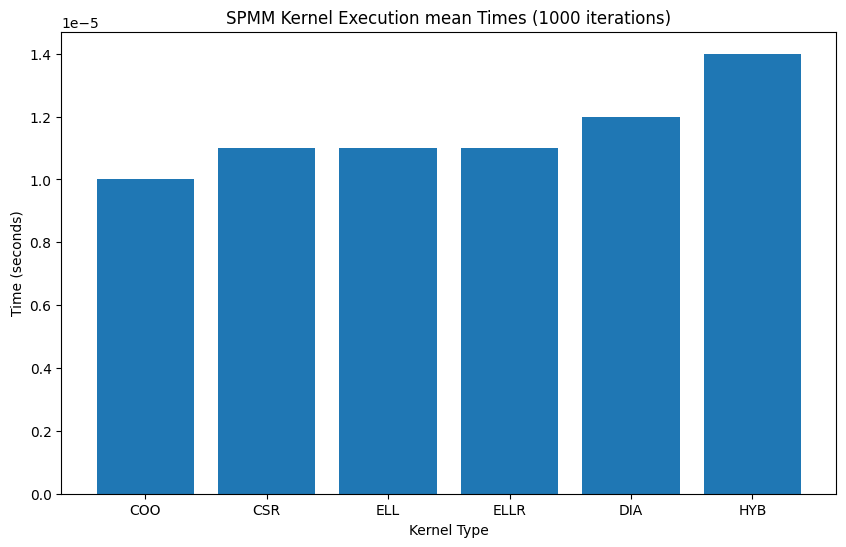

In [28]:
import matplotlib.pyplot as plt

kernels = ['COO', 'CSR', 'ELL', 'ELLR', 'DIA', 'HYB']
times = [ 0.000010, 0.000011 ,   0.000011 ,    0.000011 ,0.000012, 0.000014]  # Replace with your actual times

plt.figure(figsize=(10, 6))
plt.bar(kernels, times)
plt.title('SPMM Kernel Execution mean Times (1000 iterations)')
plt.ylabel('Time (seconds)')
plt.xlabel('Kernel Type')
plt.show()

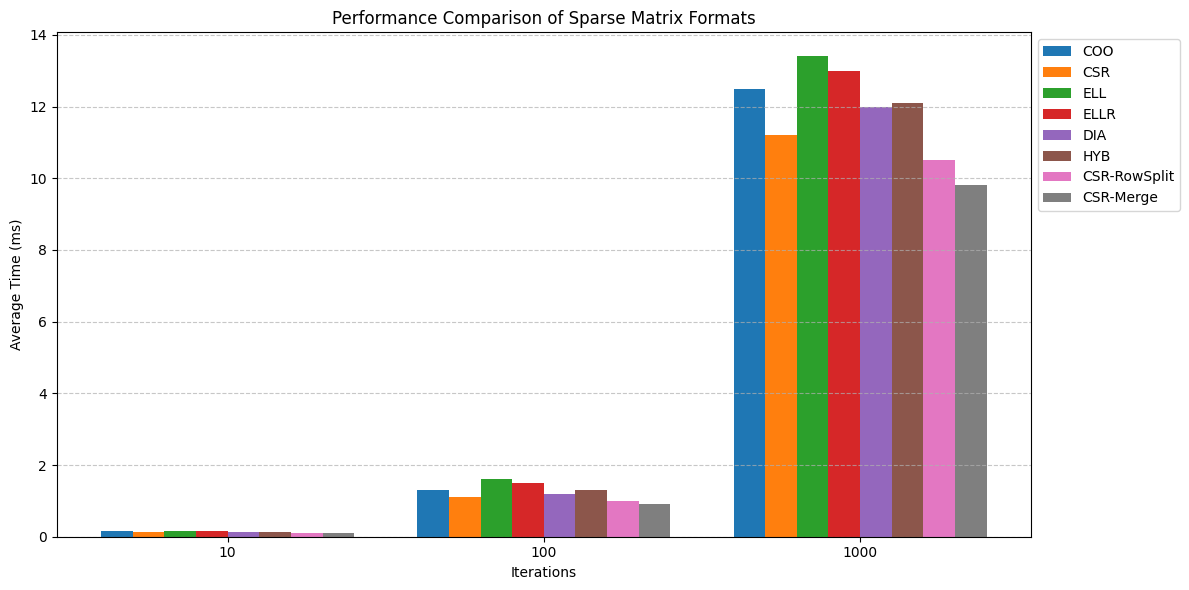

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Define all 8 formats now
formats = ['COO', 'CSR', 'ELL', 'ELLR', 'DIA', 'HYB', 'CSR-RowSplit', 'CSR-Merge']
iterations = ['10', '100', '1000']

# Placeholder average times (replace with actual data)
avg_times = [
    [0.15, 1.3, 12.5],    # COO
    [0.12, 1.1, 11.2],    # CSR
    [0.17, 1.6, 13.4],    # ELL
    [0.16, 1.5, 13.0],    # ELLR
    [0.14, 1.2, 12.0],    # DIA
    [0.13, 1.3, 12.1],    # HYB
    [0.10, 1.0, 10.5],    # CSR-RowSplit
    [0.09, 0.9, 9.8]      # CSR-Merge
]

# Bar plot settings
x = np.arange(len(iterations))  # [0, 1, 2] for 10, 100, 1000
bar_width = 0.10

fig, ax = plt.subplots(figsize=(12, 6))

# Plot each format
for i, format_name in enumerate(formats):
    offset = (i - 3.5) * bar_width  # Adjust for 8 formats
    ax.bar(x + offset, avg_times[i], bar_width, label=format_name)

# Labels and styling
ax.set_xlabel('Iterations')
ax.set_ylabel('Average Time (ms)')
ax.set_title('Performance Comparison of Sparse Matrix Formats')
ax.set_xticks(x)
ax.set_xticklabels(iterations)
ax.legend(loc='upper left', bbox_to_anchor=(1,1))
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


In [19]:
%%cuda
#include <stdio.h>
#include <math.h>
#include <cuda_runtime.h>

#define TOL 1e-6f
#define MAX_ITER 1000

#define CHECK_CUDA(call) \
do { \
    cudaError_t err = (call); \
    if (err != cudaSuccess) { \
        fprintf(stderr, "CUDA error at %s:%d - %s\n", __FILE__, __LINE__, cudaGetErrorString(err)); \
        exit(EXIT_FAILURE); \
    } \
} while (0)

// Sparse Matrix-Vector Multiplication (CSR format)
__global__ void spmv_csr(int *row_ptr, int *cols, float *vals, float *x, float *y, int n) {
    int row = blockIdx.x * blockDim.x + threadIdx.x;
    if (row < n) {
        float sum = 0.0f;
        int row_start = row_ptr[row];
        int row_end = row_ptr[row+1];
        for (int j = row_start; j < row_end; j++) {
            sum += vals[j] * x[cols[j]];
        }
        y[row] = sum;
    }
}

// Vector operation: c = alpha*a + beta*b
__global__ void vector_op(float *a, float *b, float *c, float alpha, float beta, int n) {
    int i = blockIdx.x * blockDim.x + threadIdx.x;
    if (i < n) {
        c[i] = alpha * a[i] + beta * b[i];
    }
}

// Dot product on device (more efficient than host)
__global__ void dot_product_kernel(float *a, float *b, float *result, int n) {
    __shared__ float shared_mem[256];
    int tid = threadIdx.x;
    int i = blockIdx.x * blockDim.x + tid;
    
    float sum = 0.0f;
    if (i < n) {
        sum = a[i] * b[i];
    }
    
    // Parallel reduction in shared memory
    shared_mem[tid] = sum;
    __syncthreads();
    
    for (int s = blockDim.x/2; s > 0; s >>= 1) {
        if (tid < s) {
            shared_mem[tid] += shared_mem[tid + s];
        }
        __syncthreads();
    }
    
    if (tid == 0) {
        atomicAdd(result, shared_mem[0]);
    }
}

float device_dot_product(float *d_a, float *d_b, int n) {
    float *d_result;
    float h_result = 0.0f;
    
    CHECK_CUDA(cudaMalloc(&d_result, sizeof(float)));
    CHECK_CUDA(cudaMemset(d_result, 0, sizeof(float)));
    
    dim3 block(256);
    dim3 grid((n + block.x - 1) / block.x);
    
    dot_product_kernel<<<grid, block>>>(d_a, d_b, d_result, n);
    CHECK_CUDA(cudaDeviceSynchronize());
    
    CHECK_CUDA(cudaMemcpy(&h_result, d_result, sizeof(float), cudaMemcpyDeviceToHost));
    CHECK_CUDA(cudaFree(d_result));
    
    return h_result;
}

void conjugate_gradient(int *d_row_ptr, int *d_cols, float *d_vals, 
                       float *d_b, float *d_x, int n) {
    float *d_r, *d_p, *d_Ap;
    float alpha, beta, rr, rr_new;
    
    // Allocate device memory
    CHECK_CUDA(cudaMalloc(&d_r, n * sizeof(float)));
    CHECK_CUDA(cudaMalloc(&d_p, n * sizeof(float)));
    CHECK_CUDA(cudaMalloc(&d_Ap, n * sizeof(float)));
    
    dim3 block(256);
    dim3 grid((n + block.x - 1) / block.x);
    
    // Initial residual r = b - A*x (with x=0)
    spmv_csr<<<grid, block>>>(d_row_ptr, d_cols, d_vals, d_x, d_Ap, n);
    vector_op<<<grid, block>>>(d_b, d_Ap, d_r, 1.0f, -1.0f, n);
    CHECK_CUDA(cudaMemcpy(d_p, d_r, n * sizeof(float), cudaMemcpyDeviceToDevice));
    
    rr = device_dot_product(d_r, d_r, n);
    
    for (int iter = 0; iter < MAX_ITER && sqrtf(rr) > TOL; iter++) {
        // Compute Ap = A*p
        spmv_csr<<<grid, block>>>(d_row_ptr, d_cols, d_vals, d_p, d_Ap, n);
        
        // Compute alpha = r^T*r / p^T*A*p
        float pAp = device_dot_product(d_p, d_Ap, n);
        alpha = rr / pAp;
        
        // Update x = x + alpha*p
        vector_op<<<grid, block>>>(d_x, d_p, d_x, 1.0f, alpha, n);
        
        // Update r = r - alpha*Ap
        vector_op<<<grid, block>>>(d_r, d_Ap, d_r, 1.0f, -alpha, n);
        
        // Compute new residual norm
        rr_new = device_dot_product(d_r, d_r, n);
        
        // Compute beta = r_new^T*r_new / r^T*r
        beta = rr_new / rr;
        
        // Update p = r + beta*p
        vector_op<<<grid, block>>>(d_r, d_p, d_p, 1.0f, beta, n);
        
        rr = rr_new;
        
        // Optional: Print progress
        if (iter % 10 == 0) {
            printf("Iteration %d: residual = %e\n", iter, sqrtf(rr));
        }
    }
    
    // Free device memory
    CHECK_CUDA(cudaFree(d_r));
    CHECK_CUDA(cudaFree(d_p));
    CHECK_CUDA(cudaFree(d_Ap));
}

int main() {
    // Example usage with a simple 3x3 SPD matrix
    const int n = 3;
    
    // CSR format for matrix A = [4 1 0; 1 3 1; 0 1 2]
    int row_ptr[] = {0, 2, 5, 7};
    int cols[] = {0, 1, 0, 1, 2, 1, 2};
    float vals[] = {4.0f, 1.0f, 1.0f, 3.0f, 1.0f, 1.0f, 2.0f};
    float b[] = {1.0f, 2.0f, 3.0f};
    float x[n] = {0.0f}; // Initial guess
    
    // Allocate and copy data to device
    int *d_row_ptr, *d_cols;
    float *d_vals, *d_b, *d_x;
    
    CHECK_CUDA(cudaMalloc(&d_row_ptr, (n+1) * sizeof(int)));
    CHECK_CUDA(cudaMalloc(&d_cols, row_ptr[n] * sizeof(int)));
    CHECK_CUDA(cudaMalloc(&d_vals, row_ptr[n] * sizeof(float)));
    CHECK_CUDA(cudaMalloc(&d_b, n * sizeof(float)));
    CHECK_CUDA(cudaMalloc(&d_x, n * sizeof(float)));
    
    CHECK_CUDA(cudaMemcpy(d_row_ptr, row_ptr, (n+1) * sizeof(int), cudaMemcpyHostToDevice));
    CHECK_CUDA(cudaMemcpy(d_cols, cols, row_ptr[n] * sizeof(int), cudaMemcpyHostToDevice));
    CHECK_CUDA(cudaMemcpy(d_vals, vals, row_ptr[n] * sizeof(float), cudaMemcpyHostToDevice));
    CHECK_CUDA(cudaMemcpy(d_b, b, n * sizeof(float), cudaMemcpyHostToDevice));
    CHECK_CUDA(cudaMemcpy(d_x, x, n * sizeof(float), cudaMemcpyHostToDevice));
    
    // Solve Ax = b
    conjugate_gradient(d_row_ptr, d_cols, d_vals, d_b, d_x, n);
    
    // Copy result back
    CHECK_CUDA(cudaMemcpy(x, d_x, n * sizeof(float), cudaMemcpyDeviceToHost));
    
    // Print solution
    printf("Solution:\n");
    for (int i = 0; i < n; i++) {
        printf("x[%d] = %f\n", i, x[i]);
    }
    
    // Free device memory
    CHECK_CUDA(cudaFree(d_row_ptr));
    CHECK_CUDA(cudaFree(d_cols));
    CHECK_CUDA(cudaFree(d_vals));
    CHECK_CUDA(cudaFree(d_b));
    CHECK_CUDA(cudaFree(d_x));
    
    return 0;
}

Iteration 0: residual = 1.296148e+00
Solution:
x[0] = 0.222222
x[1] = 0.111111
x[2] = 1.444444



In [45]:
%%cuda
#include <stdio.h>
#include <stdlib.h>
#include <cuda_runtime.h>
#include <sys/time.h>

#define CHECK_CUDA(call) \
    if ((call) != cudaSuccess) { \
        fprintf(stderr, "CUDA error at %s:%d\n", __FILE__, __LINE__); \
        exit(EXIT_FAILURE); \
    }

#define WARP_SIZE 32
#define BLOCK_SIZE 256
#define ROWS_PER_BLOCK 8
#define NUM_RUNS 1000

int compare_ints(const void* a, const void* b) {
    int arg1 = *(const int*)a;
    int arg2 = *(const int*)b;
    return (arg1 > arg2) - (arg1 < arg2);
}

double getCurrentTime() {
    struct timeval tv;
    gettimeofday(&tv, NULL);
    return (double)tv.tv_sec + (double)tv.tv_usec / 1000000.0;
}

// New matrix dimensions and values
const int M = 3, K = 3, N = 2;
float h_dense_B[K * N] = {1, 2, 3, 4, 5, 6};
float h_dense_C[M * N];

int coo_rows[] = {0, 0, 1, 2};
int coo_cols[] = {0, 2, 1, 2};
float coo_vals[] = {4.0, 2.0, 3.0, 5.0};
int nnz = sizeof(coo_vals) / sizeof(coo_vals[0]);

__device__ int binary_search(const int* rowptr, int nrows, int target) {
    int low = 0, high = nrows;
    while (low < high) {
        int mid = (low + high) / 2;
        if (rowptr[mid] <= target) low = mid + 1;
        else high = mid;
    }
    return low - 1;
}


__global__ void spmm_coo(int *rows, int *cols, float *vals, float *B, float *C, int nnz, int N) {
    int i = blockIdx.x * blockDim.x + threadIdx.x;
    if (i < nnz) {
        int row = rows[i], col = cols[i];
        float val = vals[i];
        for (int n = 0; n < N; n++) {
            atomicAdd(&C[row * N + n], val * B[col * N + n]);
        }
    }
}

__global__ void spmm_csr(int *row_ptr, int *cols, float *vals, float *B, float *C, int M, int N) {
    int row = blockIdx.x * blockDim.x + threadIdx.x;
    if (row < M) {
        for (int i = row_ptr[row]; i < row_ptr[row + 1]; i++) {
            int col = cols[i];
            float val = vals[i];
            for (int n = 0; n < N; n++) {
                C[row * N + n] += val * B[col * N + n];
            }
        }
    }
}

__global__ void spmm_ell(int *indices, float *data, int max_nnz, float *B, float *C, int M, int N) {
    int row = blockIdx.x * blockDim.x + threadIdx.x;
    if (row < M) {
        for (int j = 0; j < max_nnz; j++) {
            int col = indices[row * max_nnz + j];
            float val = data[row * max_nnz + j];
            if (val != 0) {
                for (int n = 0; n < N; n++) {
                    C[row * N + n] += val * B[col * N + n];
                }
            }
        }
    }
}

__global__ void spmm_ellr(int *indices, float *data, int *lengths, int max_nnz, float *B, float *C, int M, int N) {
    int row = blockIdx.x * blockDim.x + threadIdx.x;
    if (row < M) {
        int len = lengths[row];
        for (int j = 0; j < len; j++) {
            int col = indices[row * max_nnz + j];
            float val = data[row * max_nnz + j];
            for (int n = 0; n < N; n++) {
                C[row * N + n] += val * B[col * N + n];
            }
        }
    }
}

__global__ void spmm_dia(int *offsets, float *data, int num_diags, float *B, float *C, int M, int N) {
    int row = blockIdx.x * blockDim.x + threadIdx.x;
    if (row < M) {
        for (int d = 0; d < num_diags; d++) {
            int col = row + offsets[d];
            if (col >= 0 && col < K) {
                float val = data[d * M + row];
                if (val != 0) {
                    for (int n = 0; n < N; n++) {
                        C[row * N + n] += val * B[col * N + n];
                    }
                }
            }
        }
    }
}

__global__ void spmm_hyb_ell(int *ell_idx, float *ell_val, int ell_cols, float *B, float *C, int M, int N) {
    int row = blockIdx.x * blockDim.x + threadIdx.x;
    if (row < M) {
        for (int j = 0; j < ell_cols; j++) {
            float val = ell_val[row * ell_cols + j];
            int col = ell_idx[row * ell_cols + j];
            if (val != 0) {
                for (int n = 0; n < N; n++) {
                    C[row * N + n] += val * B[col * N + n];
                }
            }
        }
    }
}

__global__ void spmm_hyb_coo(int *coo_rows, int *coo_cols, float *coo_vals, int coo_nnz, float *B, float *C, int N) {
    int i = blockIdx.x * blockDim.x + threadIdx.x;
    if (i < coo_nnz) {
        int row = coo_rows[i];
        int col = coo_cols[i];
        float val = coo_vals[i];
        for (int n = 0; n < N; n++) {
            atomicAdd(&C[row * N + n], val * B[col * N + n]);
        }
    }
}

__global__ void merge_spmm_kernel(
    const int* __restrict__ row_ptr,
    const int* __restrict__ col_ind,
    const float* __restrict__ values,
    const float* __restrict__ B,
    float* __restrict__ C,
    int m, int k, int n, int total_nnz) {

    extern __shared__ int s_rowptr[];

    const int nnz_per_block = (total_nnz + gridDim.x - 1) / gridDim.x;
    const int start_nnz = min(blockIdx.x * nnz_per_block, total_nnz);
    const int end_nnz = min(start_nnz + nnz_per_block, total_nnz);
    const int start_row = binary_search(row_ptr, m+1, start_nnz);
    const int end_row = binary_search(row_ptr, m+1, end_nnz);
    const int nrows = end_row - start_row;

    for(int i = threadIdx.x; i <= nrows; i += blockDim.x) {
        s_rowptr[i] = row_ptr[start_row + i] - row_ptr[start_row];
    }
    __syncthreads();

    for(int nnz = start_nnz + threadIdx.x; nnz < end_nnz; nnz += blockDim.x) {
        int row_in_block = binary_search(s_rowptr, nrows+1, nnz - start_nnz);
        int row = start_row + row_in_block;
        int col = col_ind[nnz];
        float val = values[nnz];
        for(int j = 0; j < n; ++j) {
            float b_val = B[col * n + j];
            atomicAdd(&C[row * n + j], val * b_val);
        }
    }
}

__global__ void row_split_spmm_kernel(int* row_ptr, int* col_ind, float* values, 
                                     float* B, float* C, int m, int k, int n) {
    int warp_id = blockIdx.x * blockDim.x / WARP_SIZE + threadIdx.x / WARP_SIZE;
    int lane_id = threadIdx.x % WARP_SIZE;
    int row = warp_id;

    if (row >= m) return;
    int row_start = row_ptr[row];
    int row_end = row_ptr[row + 1];
    
    for (int i = row_start + lane_id; i < row_end; i += WARP_SIZE) {
        int col = col_ind[i];
        float val = values[i];
        for (int j = 0; j < n; j++) {
            float b_val = B[col * n + j];
            atomicAdd(&C[row * n + j], val * b_val);
        }
    }
}

void print_matrix(float *mat, int rows, int cols, const char* name) {
    printf("%s (%dx%d):\n", name, rows, cols);
    for (int i = 0; i < rows; i++) {
        for (int j = 0; j < cols; j++) {
            printf("%6.1f", mat[i*cols + j]);
        }
        printf("\n");
    }
    printf("\n");
}

void print_csr_matrix(int *row_ptr, int *col_ind, float *values, int m, int nnz, const char* name) {
    printf("%s (CSR format, %dx%d with %d non-zeros):\n", name, m, m, nnz);
    printf("row_ptr: ");
    for(int i=0; i<=m; i++) printf("%d ", row_ptr[i]);
    printf("\ncol_ind: ");
    for(int i=0; i<nnz; i++) printf("%d ", col_ind[i]);
    printf("\nvalues:  ");
    for(int i=0; i<nnz; i++) printf("%.1f ", values[i]);
    printf("\n\n");
}

void print_mean_execution_times(double *mean_times, const char **names, int count) {
    printf("\nMean Kernel Execution Times (averaged over %d runs):\n", NUM_RUNS);
    printf("+---------------+----------------+\n");
    printf("| Format        | Time (seconds) |\n");
    printf("+---------------+----------------+\n");
    for (int i = 0; i < count; i++) {
        printf("| %-13s | %14.6f |\n", names[i], mean_times[i]);
    }
    printf("+---------------+----------------+\n\n");
    
    printf("CSV Format:\n");
    printf("Format,Time\n");
    for (int i = 0; i < count; i++) {
        printf("%s,%.6f\n", names[i], mean_times[i]);
    }
}

void run_coo(float *d_B, float *d_C, int *d_coo_rows, int *d_coo_cols, float *d_coo_vals, int block, double *execution_time) {
    double total_time = 0.0;
    for (int run = 0; run < NUM_RUNS; run++) {
        cudaMemset(d_C, 0, M * N * sizeof(float));
        double start = getCurrentTime();
        spmm_coo<<<(nnz + block - 1) / block, block>>>(d_coo_rows, d_coo_cols, d_coo_vals, d_B, d_C, nnz, N);
        cudaDeviceSynchronize();
        total_time += getCurrentTime() - start;
    }
    *execution_time = total_time / NUM_RUNS;
}

void run_csr(float *d_B, float *d_C, int *d_csr_row, int *d_csr_col, float *d_csr_val, int block, double *execution_time) {
    double total_time = 0.0;
    for (int run = 0; run < NUM_RUNS; run++) {
        cudaMemset(d_C, 0, M * N * sizeof(float));
        double start = getCurrentTime();
        spmm_csr<<<(M + block - 1) / block, block>>>(d_csr_row, d_csr_col, d_csr_val, d_B, d_C, M, N);
        cudaDeviceSynchronize();
        total_time += getCurrentTime() - start;
    }
    *execution_time = total_time / NUM_RUNS;
}

void run_row_split_csr(float *d_B, float *d_C, int *d_csr_row, int *d_csr_col, float *d_csr_val, int block, double *execution_time) {
    double total_time = 0.0;
    dim3 blockDim(32*N);
    dim3 gridDim(M);
    
    for (int run = 0; run < NUM_RUNS; run++) {
        cudaMemset(d_C, 0, M * N * sizeof(float));
        double start = getCurrentTime();
        row_split_spmm_kernel<<<gridDim, blockDim>>>(d_csr_row, d_csr_col, d_csr_val, d_B, d_C, M, K, N);
        cudaDeviceSynchronize();
        total_time += getCurrentTime() - start;
    }
    *execution_time = total_time / NUM_RUNS;
}

void run_merge_csr(float *d_B, float *d_C, int *d_csr_row, int *d_csr_col, float *d_csr_val, int block, double *execution_time) {
    double total_time = 0.0;
    int num_blocks = (nnz + block - 1) / block;

    // TEMP device copy of CSR row pointer to compute max shared memory needed
    int h_row_ptr[M + 1];
    CHECK_CUDA(cudaMemcpy(h_row_ptr, d_csr_row, (M + 1) * sizeof(int), cudaMemcpyDeviceToHost));
    int max_rows_per_block = 0;
    for (int i = 0; i < M; i++) {
        int row_start = h_row_ptr[i];
        int row_end = h_row_ptr[i+1];
        int row_nnz = row_end - row_start;
        if (row_nnz > 0) max_rows_per_block++;
    }

    size_t shared_mem = (max_rows_per_block + 1) * sizeof(int);

    for (int run = 0; run < NUM_RUNS; run++) {
        cudaMemset(d_C, 0, M * N * sizeof(float));
        double start = getCurrentTime();
        merge_spmm_kernel<<<num_blocks, block, shared_mem>>>(
            d_csr_row, d_csr_col, d_csr_val, d_B, d_C, M, K, N, nnz);
        cudaDeviceSynchronize();
        total_time += getCurrentTime() - start;
    }

    *execution_time = total_time / NUM_RUNS;
}

void run_ell(float *d_B, float *d_C, int *d_ell_idx, float *d_ell_val, int max_per_row, int block, double *execution_time) {
    double total_time = 0.0;
    for (int run = 0; run < NUM_RUNS; run++) {
        cudaMemset(d_C, 0, M * N * sizeof(float));
        double start = getCurrentTime();
        spmm_ell<<<(M + block - 1) / block, block>>>(d_ell_idx, d_ell_val, max_per_row, d_B, d_C, M, N);
        cudaDeviceSynchronize();
        total_time += getCurrentTime() - start;
    }
    *execution_time = total_time / NUM_RUNS;
}

void run_ellr(float *d_B, float *d_C, int *d_ell_idx, float *d_ell_val, int *d_lengths, int max_per_row, int block, double *execution_time) {
    double total_time = 0.0;
    for (int run = 0; run < NUM_RUNS; run++) {
        cudaMemset(d_C, 0, M * N * sizeof(float));
        double start = getCurrentTime();
        spmm_ellr<<<(M + block - 1) / block, block>>>(d_ell_idx, d_ell_val, d_lengths, max_per_row, d_B, d_C, M, N);
        cudaDeviceSynchronize();
        total_time += getCurrentTime() - start;
    }
    *execution_time = total_time / NUM_RUNS;
}

void run_dia(float *d_B, float *d_C, int *d_offsets, float *d_dia_data, int num_diags, int block, double *execution_time) {
    double total_time = 0.0;
    for (int run = 0; run < NUM_RUNS; run++) {
        cudaMemset(d_C, 0, M * N * sizeof(float));
        double start = getCurrentTime();
        spmm_dia<<<(M + block - 1) / block, block>>>(d_offsets, d_dia_data, num_diags, d_B, d_C, M, N);
        cudaDeviceSynchronize();
        total_time += getCurrentTime() - start;
    }
    *execution_time = total_time / NUM_RUNS;
}

void run_hyb(float *d_B, float *d_C, int *d_hyb_ell_idx, float *d_hyb_ell_val, int ell_cols, 
             int *d_hyb_coo_r, int *d_hyb_coo_c, float *d_hyb_coo_v, int hyb_coo_nnz, int block, double *execution_time) {
    double total_time = 0.0;
    for (int run = 0; run < NUM_RUNS; run++) {
        cudaMemset(d_C, 0, M * N * sizeof(float));
        double start = getCurrentTime();
        spmm_hyb_ell<<<(M + block - 1) / block, block>>>(d_hyb_ell_idx, d_hyb_ell_val, ell_cols, d_B, d_C, M, N);
        if (hyb_coo_nnz > 0) {
            spmm_hyb_coo<<<(hyb_coo_nnz + block - 1) / block, block>>>(d_hyb_coo_r, d_hyb_coo_c, d_hyb_coo_v, hyb_coo_nnz, d_B, d_C, N);
        }
        cudaDeviceSynchronize();
        total_time += getCurrentTime() - start;
    }
    *execution_time = total_time / NUM_RUNS;
}

int main() {
    // Print input matrices
    int csr_row_ptr[] = {0, 2, 3, 4};
    print_csr_matrix(csr_row_ptr, coo_cols, coo_vals, M, nnz, "Sparse Matrix A");
    print_matrix(h_dense_B, K, N, "Dense Matrix B");

    // Device memory pointers
    float *d_B, *d_C;
    int *d_coo_rows, *d_coo_cols;
    float *d_coo_vals;
    int *d_csr_row, *d_csr_col;
    float *d_csr_val;
    int *d_ell_idx, *d_lengths;
    float *d_ell_val;
    int *d_offsets;
    float *d_dia_data;
    int *d_hyb_ell_idx, *d_hyb_coo_r, *d_hyb_coo_c;
    float *d_hyb_ell_val, *d_hyb_coo_v;

    // Allocate and copy common matrices
    CHECK_CUDA(cudaMalloc(&d_B, K * N * sizeof(float)));
    CHECK_CUDA(cudaMalloc(&d_C, M * N * sizeof(float)));
    CHECK_CUDA(cudaMemcpy(d_B, h_dense_B, K * N * sizeof(float), cudaMemcpyHostToDevice));

    int block = 256;
    int num_kernels = 8;
    double mean_times[8];
    const char *kernel_names[8] = {"COO", "CSR", "Row-Split CSR", "Merge CSR", "ELL", "ELLR", "DIA", "HYB"};

    // ===== COO =====
    CHECK_CUDA(cudaMalloc(&d_coo_rows, nnz * sizeof(int)));
    CHECK_CUDA(cudaMalloc(&d_coo_cols, nnz * sizeof(int)));
    CHECK_CUDA(cudaMalloc(&d_coo_vals, nnz * sizeof(float)));
    CHECK_CUDA(cudaMemcpy(d_coo_rows, coo_rows, nnz * sizeof(int), cudaMemcpyHostToDevice));
    CHECK_CUDA(cudaMemcpy(d_coo_cols, coo_cols, nnz * sizeof(int), cudaMemcpyHostToDevice));
    CHECK_CUDA(cudaMemcpy(d_coo_vals, coo_vals, nnz * sizeof(float), cudaMemcpyHostToDevice));
    
    run_coo(d_B, d_C, d_coo_rows, d_coo_cols, d_coo_vals, block, &mean_times[0]);
    cudaMemcpy(h_dense_C, d_C, M * N * sizeof(float), cudaMemcpyDeviceToHost);
    printf("COO Output:\n"); print_matrix(h_dense_C, M, N, "Result C");

    // ===== CSR =====
    CHECK_CUDA(cudaMalloc(&d_csr_row, (M + 1) * sizeof(int)));
    CHECK_CUDA(cudaMalloc(&d_csr_col, nnz * sizeof(int)));
    CHECK_CUDA(cudaMalloc(&d_csr_val, nnz * sizeof(float)));
    CHECK_CUDA(cudaMemcpy(d_csr_row, csr_row_ptr, (M + 1) * sizeof(int), cudaMemcpyHostToDevice));
    CHECK_CUDA(cudaMemcpy(d_csr_col, coo_cols, nnz * sizeof(int), cudaMemcpyHostToDevice));
    CHECK_CUDA(cudaMemcpy(d_csr_val, coo_vals, nnz * sizeof(float), cudaMemcpyHostToDevice));
    
    run_csr(d_B, d_C, d_csr_row, d_csr_col, d_csr_val, block, &mean_times[1]);
    cudaMemcpy(h_dense_C, d_C, M * N * sizeof(float), cudaMemcpyDeviceToHost);
    printf("CSR Output:\n"); print_matrix(h_dense_C, M, N, "Result C");

    // ===== Row-Split CSR =====
    run_row_split_csr(d_B, d_C, d_csr_row, d_csr_col, d_csr_val, block, &mean_times[2]);
    cudaMemcpy(h_dense_C, d_C, M * N * sizeof(float), cudaMemcpyDeviceToHost);
    printf("Row-Split CSR Output:\n"); print_matrix(h_dense_C, M, N, "Result C");

    // ===== Merge CSR =====
    run_merge_csr(d_B, d_C, d_csr_row, d_csr_col, d_csr_val, block, &mean_times[3]);
    cudaMemcpy(h_dense_C, d_C, M * N * sizeof(float), cudaMemcpyDeviceToHost);
    printf("Merge CSR Output:\n"); print_matrix(h_dense_C, M, N, "Result C");

    // ===== ELL =====
    int max_per_row = 2;
    int *ell_idx = (int*)malloc(M * max_per_row * sizeof(int));
    float *ell_val = (float*)malloc(M * max_per_row * sizeof(float));
    memset(ell_idx, 0, M * max_per_row * sizeof(int));
    memset(ell_val, 0, M * max_per_row * sizeof(float));
    for (int i = 0; i < nnz; i++) {
        int r = coo_rows[i], c = coo_cols[i];
        float v = coo_vals[i];
        for (int j = 0; j < max_per_row; j++) {
            if (ell_val[r * max_per_row + j] == 0) {
                ell_idx[r * max_per_row + j] = c;
                ell_val[r * max_per_row + j] = v;
                break;
            }
        }
    }
    CHECK_CUDA(cudaMalloc(&d_ell_idx, M * max_per_row * sizeof(int)));
    CHECK_CUDA(cudaMalloc(&d_ell_val, M * max_per_row * sizeof(float)));
    CHECK_CUDA(cudaMemcpy(d_ell_idx, ell_idx, M * max_per_row * sizeof(int), cudaMemcpyHostToDevice));
    CHECK_CUDA(cudaMemcpy(d_ell_val, ell_val, M * max_per_row * sizeof(float), cudaMemcpyHostToDevice));
    free(ell_idx);
    free(ell_val);
    
    run_ell(d_B, d_C, d_ell_idx, d_ell_val, max_per_row, block, &mean_times[4]);
    cudaMemcpy(h_dense_C, d_C, M * N * sizeof(float), cudaMemcpyDeviceToHost);
    printf("ELL Output:\n"); print_matrix(h_dense_C, M, N, "Result C");

    // ===== ELLR =====
    int row_lens[] = {2, 1, 1};
    CHECK_CUDA(cudaMalloc(&d_lengths, M * sizeof(int)));
    CHECK_CUDA(cudaMemcpy(d_lengths, row_lens, M * sizeof(int), cudaMemcpyHostToDevice));
    
    run_ellr(d_B, d_C, d_ell_idx, d_ell_val, d_lengths, max_per_row, block, &mean_times[5]);
    cudaMemcpy(h_dense_C, d_C, M * N * sizeof(float), cudaMemcpyDeviceToHost);
    printf("ELLPACK-R Output:\n"); print_matrix(h_dense_C, M, N, "Result C");

    // ===== DIA =====
    int *diags = (int*)malloc(nnz * sizeof(int));
    int num_diags = 0;
    for (int i = 0; i < nnz; i++) {
        int diag = coo_cols[i] - coo_rows[i];
        int found = 0;
        for (int j = 0; j < num_diags; j++) {
            if (diags[j] == diag) {
                found = 1;
                break;
            }
        }
        if (!found) {
            diags[num_diags++] = diag;
        }
    }
    qsort(diags, num_diags, sizeof(int), compare_ints);
    
    float *dia_data = (float*)calloc(num_diags * M, sizeof(float));
    for (int i = 0; i < nnz; i++) {
        int r = coo_rows[i], c = coo_cols[i];
        float v = coo_vals[i];
        int diag = c - r;
        for (int d = 0; d < num_diags; d++) {
            if (diags[d] == diag) {
                dia_data[d * M + r] = v;
                break;
            }
        }
    }
    CHECK_CUDA(cudaMalloc(&d_offsets, num_diags * sizeof(int)));
    CHECK_CUDA(cudaMalloc(&d_dia_data, num_diags * M * sizeof(float)));
    CHECK_CUDA(cudaMemcpy(d_offsets, diags, num_diags * sizeof(int), cudaMemcpyHostToDevice));
    CHECK_CUDA(cudaMemcpy(d_dia_data, dia_data, num_diags * M * sizeof(float), cudaMemcpyHostToDevice));
    free(diags);
    free(dia_data);
    
    run_dia(d_B, d_C, d_offsets, d_dia_data, num_diags, block, &mean_times[6]);
    cudaMemcpy(h_dense_C, d_C, M * N * sizeof(float), cudaMemcpyDeviceToHost);
    printf("DIA Output:\n"); print_matrix(h_dense_C, M, N, "Result C");

    // ===== HYB =====
    int ell_cols = 1;
    int *hyb_ell_idx = (int*)malloc(M * ell_cols * sizeof(int));
    float *hyb_ell_val = (float*)malloc(M * ell_cols * sizeof(float));
    memset(hyb_ell_idx, 0, M * ell_cols * sizeof(int));
    memset(hyb_ell_val, 0, M * ell_cols * sizeof(float));
    
    int *count_per_row = (int*)calloc(M, sizeof(int));
    int hyb_coo_nnz = 0;
    for (int i = 0; i < nnz; i++) {
        int row = coo_rows[i];
        if (count_per_row[row] >= ell_cols) {
            hyb_coo_nnz++;
        } else {
            count_per_row[row]++;
        }
    }
    
    int *hyb_coo_r = (int*)malloc(hyb_coo_nnz * sizeof(int));
    int *hyb_coo_c = (int*)malloc(hyb_coo_nnz * sizeof(int));
    float *hyb_coo_v = (float*)malloc(hyb_coo_nnz * sizeof(float));
    
    memset(count_per_row, 0, M * sizeof(int));
    int coo_idx = 0;
    for (int i = 0; i < nnz; i++) {
        int row = coo_rows[i], col = coo_cols[i];
        float val = coo_vals[i];
        if (count_per_row[row] < ell_cols) {
            hyb_ell_idx[row * ell_cols + count_per_row[row]] = col;
            hyb_ell_val[row * ell_cols + count_per_row[row]] = val;
            count_per_row[row]++;
        } else {
            hyb_coo_r[coo_idx] = row;
            hyb_coo_c[coo_idx] = col;
            hyb_coo_v[coo_idx] = val;
            coo_idx++;
        }
    }
    
    CHECK_CUDA(cudaMalloc(&d_hyb_ell_idx, M * ell_cols * sizeof(int)));
    CHECK_CUDA(cudaMalloc(&d_hyb_ell_val, M * ell_cols * sizeof(float)));
    CHECK_CUDA(cudaMalloc(&d_hyb_coo_r, hyb_coo_nnz * sizeof(int)));
    CHECK_CUDA(cudaMalloc(&d_hyb_coo_c, hyb_coo_nnz * sizeof(int)));
    CHECK_CUDA(cudaMalloc(&d_hyb_coo_v, hyb_coo_nnz * sizeof(float)));
    
    CHECK_CUDA(cudaMemcpy(d_hyb_ell_idx, hyb_ell_idx, M * ell_cols * sizeof(int), cudaMemcpyHostToDevice));
    CHECK_CUDA(cudaMemcpy(d_hyb_ell_val, hyb_ell_val, M * ell_cols * sizeof(float), cudaMemcpyHostToDevice));
    CHECK_CUDA(cudaMemcpy(d_hyb_coo_r, hyb_coo_r, hyb_coo_nnz * sizeof(int), cudaMemcpyHostToDevice));
    CHECK_CUDA(cudaMemcpy(d_hyb_coo_c, hyb_coo_c, hyb_coo_nnz * sizeof(int), cudaMemcpyHostToDevice));
    CHECK_CUDA(cudaMemcpy(d_hyb_coo_v, hyb_coo_v, hyb_coo_nnz * sizeof(float), cudaMemcpyHostToDevice));
    
    run_hyb(d_B, d_C, d_hyb_ell_idx, d_hyb_ell_val, ell_cols, 
            d_hyb_coo_r, d_hyb_coo_c, d_hyb_coo_v, hyb_coo_nnz, block, &mean_times[7]);
    cudaMemcpy(h_dense_C, d_C, M * N * sizeof(float), cudaMemcpyDeviceToHost);
    printf("HYB Output:\n"); print_matrix(h_dense_C, M, N, "Result C");
    
    // Cleanup
    free(hyb_ell_idx);
    free(hyb_ell_val);
    free(count_per_row);
    free(hyb_coo_r);
    free(hyb_coo_c);
    free(hyb_coo_v);

    // Print performance results
    print_mean_execution_times(mean_times, kernel_names, num_kernels);

    // Final cleanup
    CHECK_CUDA(cudaFree(d_B));
    CHECK_CUDA(cudaFree(d_C));
    CHECK_CUDA(cudaFree(d_coo_rows));
    CHECK_CUDA(cudaFree(d_coo_cols));
    CHECK_CUDA(cudaFree(d_coo_vals));
    CHECK_CUDA(cudaFree(d_csr_row));
    CHECK_CUDA(cudaFree(d_csr_col));
    CHECK_CUDA(cudaFree(d_csr_val));
    CHECK_CUDA(cudaFree(d_ell_idx));
    CHECK_CUDA(cudaFree(d_ell_val));
    CHECK_CUDA(cudaFree(d_lengths));
    CHECK_CUDA(cudaFree(d_offsets));
    CHECK_CUDA(cudaFree(d_dia_data));
    CHECK_CUDA(cudaFree(d_hyb_ell_idx));
    CHECK_CUDA(cudaFree(d_hyb_ell_val));
    CHECK_CUDA(cudaFree(d_hyb_coo_r));
    CHECK_CUDA(cudaFree(d_hyb_coo_c));
    CHECK_CUDA(cudaFree(d_hyb_coo_v));

    return 0;
}

Sparse Matrix A (CSR format, 3x3 with 4 non-zeros):
row_ptr: 0 2 3 4 
col_ind: 0 2 1 2 
values:  4.0 2.0 3.0 5.0 

Dense Matrix B (3x2):
   1.0   2.0
   3.0   4.0
   5.0   6.0

COO Output:
Result C (3x2):
  14.0  20.0
   9.0  12.0
  25.0  30.0

CSR Output:
Result C (3x2):
  14.0  20.0
   9.0  12.0
  25.0  30.0

Row-Split CSR Output:
Result C (3x2):
  14.0  20.0
   9.0  12.0
  25.0  30.0

Merge CSR Output:
Result C (3x2):
  14.0  20.0
   9.0  12.0
  25.0  30.0

ELL Output:
Result C (3x2):
  14.0  20.0
   9.0  12.0
  25.0  30.0

ELLPACK-R Output:
Result C (3x2):
  14.0  20.0
   9.0  12.0
  25.0  30.0

DIA Output:
Result C (3x2):
  14.0  20.0
   9.0  12.0
  25.0  30.0

HYB Output:
Result C (3x2):
  14.0  20.0
   9.0  12.0
  25.0  30.0


Mean Kernel Execution Times (averaged over 1000 runs):
+---------------+----------------+
| Format        | Time (seconds) |
+---------------+----------------+
| COO           |       0.000121 |
| CSR           |       0.000011 |
| Row-Split CSR |       0.